In [1]:
using Pkg
# Pkg.activate("/Users/ryansenne/Documents/Github/SSM/")
Pkg.activate("/home/ryansenne/PycharmProjects/ssm_julia/")

  Activating project at `~/PycharmProjects/ssm_julia`


In [2]:
# include("/Users/ryansenne/Documents/Github/SSM//src/SSM.jl")
include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using Random
using .SSM
using Distributions

### Gaussian GLM Example

In [3]:
# Fit a Gaussian GLM
# Generate some synthetic data
X = rand(10000, 3);  # 100 samples, 3 features;
# Add a column of ones to represent the intercept term
X_concat = hcat(ones(10000), X)
β = [2, 3, -4, 5]
y = X_concat * β + rand(Normal(0, 1), 10000)

# define a GLM
glm = GaussianRegression(X, y)
fit!(glm, LSELoss(), 1000)

4-element Vector{Float64}:
  2.021116022471413
  3.0089984007284456
 -4.035554508045178
  4.983068117343782

### Poisson GLM Example

In [4]:
# Fit a Poisson GLM
# Generate some synthetic data
X = rand(10000, 3);  # 100 samples, 3 features;
# Add a column of ones to represent the intercept term
X_concat = hcat(ones(10000), X)
β = [2, 3, -4, 5]

# Generate some synthetic data
y = Vector{Float64}(rand.(Poisson.(exp.(X_concat * β))))

# define a GLM
glm = PoissonRegression(X, y)
fit!(glm, PoissonLoss(), 1000)


4-element Vector{Float64}:
  1.9966739446843178
  2.998519547664794
 -3.996165671256736
  5.003232682420597

### Binomial GLM Example (i.e. logistic regression)

In [5]:
# sigmoid function
function sigmoid(x)
    return 1 / (1 + exp(-x))
end

# Fit a Binomial GLM
# Generate some synthetic data
X = rand(10000, 3); # 1000 samples, 3 features;
# Add a column of ones to represent the intercept term
X_concat = hcat(ones(10000), X)
β = [2, 3, -4, 5]

# Generate some synthetic data
y = Vector{Float64}(rand.(Binomial.(1, sigmoid.(X_concat * β))))

# define a GLM
glm = BinomialRegression(X, y)
fit!(glm, CrossEntropyLoss(), 1000)

4-element Vector{Float64}:
  2.0802937202555123
  3.096043961377644
 -4.172322946230162
  4.910467134773006

In [19]:
# try out markov glm

# Generate synthetic data from two distinct regimes
X = rand(100, 3); # 1000 samples, 3 features;
# Add a column of ones to represent the intercept term
X_concat = hcat(ones(100), X)
β₁ = [-20, -30, -40, 50]
β₂ = [6, 7, 8, -9]

# Generate some synthetic data
y₁ = X_concat * β₁ + rand(Normal(0, 0.1), 100)
y₂ = X_concat * β₂ + rand(Normal(0, 1), 100)

# concatenate X1 and X2
x = vcat(X, X)

# concatenate y1 and y2
y = vcat(y₁, y₂)

# define a Gaussian HMMGLM
glm = GaussianMarkovRegression(y, x, 2)

# MarkovRegressionEM(glm)

Iteration: 1, Log-likelihood: -863.8350064674594
Iteration: 2, Log-likelihood: -851.0840896601919
Iteration: 3, Log-likelihood: -840.9796100934342
Iteration: 4, Log-likelihood: -835.5589581419814
Iteration: 5, Log-likelihood: -833.1354293466231
Iteration: 6, Log-likelihood: -832.2304480261721
Iteration: 7, Log-likelihood: -831.9364260063733
Iteration: 8, Log-likelihood: -831.8397301492631
Convergence reached at iteration 8
Initial Variance: [935.6988519873989, 1128.3428430943313]
Initial Transition Matrix: [0.9270833333333334 0.07291666666666667; 0.05825242718446602 0.941747572815534]
Initial Mixing Coefficients: [1.0, 5.370853094793658e-47]


GaussianMarkovRegression{Float64}([-49.47735034497325, -22.417434635173258, -30.57161505728204, -27.397100465868153, -35.14538316220959, -35.99905407588847, -32.21687019119702, -14.073496284958987, -47.700885058839575, -54.70368966642304  …  16.04902630112694, 17.836181458878013, 8.17983081457461, 3.325198284240657, 10.980823351646142, 16.617168897695098, 8.168635205066018, 8.006370744679268, 8.93391129160764, 9.380103071181594], [0.9629598834473634 0.36094614275953507 0.27666145180228563; 0.18047783906733916 0.5425789345542085 0.49626476375330486; … ; 0.1298199604958271 0.761591978863015 0.5858650042728012; 0.13911322142285232 0.7823202291438952 0.43546124877663295], 2, [0.9270833333333334 0.07291666666666667; 0.05825242718446602 0.941747572815534], [1.0, 5.370853094793658e-47], Main.SSM.RegressionEmissions[Main.SSM.RegressionEmissions(GaussianRegression{Float64}([1.0 0.9629598834473634 0.36094614275953507 0.27666145180228563; 1.0 0.18047783906733916 0.5425789345542085 0.4962647637533

In [13]:
glm.σ²

2-element Vector{Float64}:
 36537.28626420188
 36537.354581221465

In [5]:
glm.A

2×2 Matrix{Float64}:
 0.53148      0.46852
 0.000742264  0.999258

In [6]:
glm.πₖ

2-element Vector{Float64}:
 0.5000000075259305
 0.4999999924740695

In [7]:
glm.B[1].regression_model.β

4-element Vector{Float64}:
 -101.28212575485736
 -157.7414540307949
 -194.53323837773758
  266.19014125225823

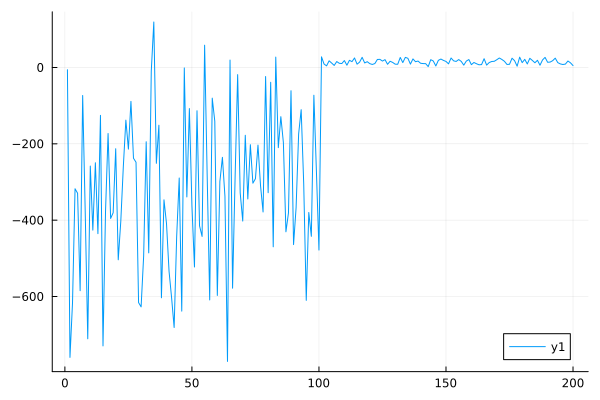

In [4]:
using Plots
plot(y)

In [20]:
α, β = SSM.EStep(glm)

([-987.6739630872795 -1975.4236379962947 … -196562.1076968401 -197549.85736211334; -1100.456481818753 -1984.2083703367184 … -196570.89046015104 -197558.64012542428], [-196562.183245685 -195574.43358041177 … -987.7495218686523 0.0; -196564.9485343528 -195577.19886907956 … -990.4859578269734 0.0])

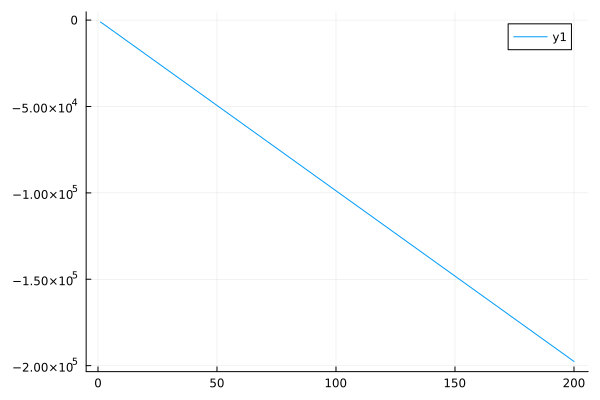

In [24]:
plot(α[2, :])